In [1]:
import scipy.linalg as la

# Continuous time to Discrete time zero-order hold method
def c2d_zoh(A, B, Ts):
    # Zero Order Hold Discrate Time Model
    nx = A.shape[0]
    nu = B.shape[1]

    # Create Extended Linear System
    M = np.zeros((nx + nu, nx + nu))
    M[0:nx, 0:nx] = A * Ts
    M[0:nx, nx:] = B * Ts
    M_d = la.expm(M)  # Convert to Discrete Time

    A_d = M_d[0:nx, 0:nx]  # Pull out A Matrix
    B_d = M_d[0:nx, nx:]  # Pull out B Matrix

    return A_d, B_d



In [2]:
# Block Matrix
# Let's you do "sub" matrix blocks inside a larger matrix
import numpy as np
from numpy.lib.stride_tricks import as_strided

class BlockMatrix():
    def __init__(self, rows = 1, cols = 1, block_height = 1, block_width=1, init_val = 0.):
        self.shape = [rows, cols]
        self._array = np.full((rows*block_height, cols*block_width), init_val)
        self.strides = self._array.strides
        self._block_array = as_strided(self._array, 
                                       shape=(rows,cols,block_height,block_width), 
                                       strides=(block_height*self.strides[0], 
                                                block_width*self.strides[1], 
                                                self.strides[0], 
                                                self.strides[1]))
    
        # Cache for speed up of diagonals setting
        self.idx = {}
        for i in range(max(self.shape[0], self.shape[1])):
            self.idx[i] = np.nonzero(np.eye(self.shape[0], self.shape[1], i))
            self.idx[-i] = np.nonzero(np.eye(self.shape[0], self.shape[1], -i))
        
        
    def fill_diagonal(self, val, k = 0):
        self._block_array[self.idx[k]] = val
        return
                
    @property
    def array(self):
        return self._array
    
    def __getitem__(self, pos):
        row, col = pos
        return self._block_array[pos[0], pos[1]]
    
    def __setitem__(self, pos, val):
        
        # TODO: Checks for correct array size, etc
        row, col = pos
        self._block_array[pos[0], pos[1]] = val
        
#b = diag_block_mat_slicing((np.array([[2,2],[3,4]]),np.array([[2,2],[3,4]]),np.array([[2,2],[3,4]])))
#print(b)
#bm = BlockMatrix(3, 3, 2, 2)
#print(bm[0,0])
#bm[0,0] = np.array([[1,2],[3,4]])
#print(bm[0,0])
#print(bm.array)
#bm.array = np.array([[2,2],[3,4]])
#bm.fill_diagonal(np.array([[1,2],[3,4]]), -2)
#bm.fill_diagonal(np.array([[2,2],[3,4]]), 0)
#print(bm.array)

#print(bm.array)
#bm[0,0] = np.ones((2,2))*11
#bm.set_item(0,0,np.ones((2,2))*11)
#print(bm.array)
#bm[0,0]
#bm.get_item(0,0)

In [3]:
from casadi import *
import numpy as np
from time import time

# Wrap Casadi for easy NLPs and QP problem solving
class VariableMeta():
    
    name = None # Variable Name
    idx = 0 # Offset index into 1D list arrays
    n = 1 # Variable Row Dimrension
    m = 1 # Variable Col Dimension
    lb = [] # Lower Bounds
    ub = [] # Upper Bounds
    x0 = [] # Initial Value
    
class ParameterMeta():
    name = None # Variable Name
    idx = 0 # Offset index into 1D list arrays
    n = 1 # Variable Row Dimension
    m = 1 # Variable Col Dimension
    value = [] # Initial Value
    
class ConstraintMeta():
    name = None # Constraint Name
    idx = 0 # Offset index into 1D list arrays
    n = 1 # Length of Constraints
    lb = [] # Lower Bounds
    ub = [] # Upper Bounds
    
class NonLinearProgramSolver(object):
    def __init__(self):
        
        self.solver = None # Solver Instance
        
        self.var_dict = {} # Decision Variable Symbol Lookup
        self.x = [] # Decision Variables Expressions Vector
        self.x0 = [] # Initial Conditions Vector
        self.x_lb = [] # Decision Variables Lower Bounds Vector
        self.x_ub = [] # Decision Variables Upper Bounds Vector
        
        self.cons_dict = {} # Constraint Symbol Lookup
        self.g = [] # Constraints Vector
        self.g_lb = [] # Constrain Lower Bounds Vector
        self.g_ub = [] # Constraint Upper Bounds Vector
        
        self.param_dict = {} # Parameter Symbol Lookup
        self.p = [] # Symbolic Parameter List
        
        self.p_values = [] # Parameter Values
        self._dirty = True # Check for solver status, if we need to reprocess
        
        self.j = 0 # Cost Function
        
        self.solution = None # Solver SOlutions
        
        self.var_count = 0 # Variable Count
        self.param_count = 0 # Parameter Count
        self.cons_count = 0 # Constraint Count
        
        # Debugging Print Variables.  Needs to come from a better options dictionary blah
        self.print_level = 0
        self.print_time = 0
         
    # TODO: Solver Type...
    def _create(self):
        nlp = {'x':vertcat(*self.x), 
       'f':self.j, 
       'g':vertcat(*self.g), 
       'p':vertcat(*self.p)}
        
        opts = {}
        opts["qpsol"] = "qpoases"
        opts["qpsol_options"] = {"printLevel":"none"}

        #opts["ipopt"] = {"max_iter":1000, 
        #                "print_level":self.print_level, 
        #                 "acceptable_tol":1e-8, 
        #                 "acceptable_obj_change_tol":1e-6,
        #                 "linear_solver":'mumps'} # Optimallity Convergence Tolerance

        opts["print_time"] = self.print_time
        opts["expand"] = True
        #self.solver = nlpsol('solver', 'ipopt',nlp, opts)
        self.solver = qpsol('solver', 'qpoases', nlp, {'sparse':False, 'printLevel':'none'})
        self._dirty = False

    def solve(self):
        if self._dirty is True:
            self._create() # Update Problem
        
        t_solve_start = time()
        self.solution = self.solver(x0=self.x0, # Initial Conditions
                                    lbx=self.x_lb, # Lower bounds on decision variables
                                    ubx=self.x_ub,  # Upper bounds on decision variables
                                    lbg=self.g_lb,  # Lower bounds on constraints
                                    ubg=self.g_ub,  # Upper boundson constraints
                                    p=self.p_values) # Paramter (fixed) variables

        #print(self.solver.stats())
        #print("Time: ", time() - t_solve_start)
        
        # TODO: Return solution dict of variables...
        #return self.solution['x'].full().flatten()
        # TODO: Verify Solved.  Optimal vs Non-Optimal, Infeasable etc.
        return True
        
    def add_variable(self, name, n=1, m=1, init=None, lb=[-inf], ub=[inf]):
        
        # Do Some Data Formatting
        if isinstance(init, np.ndarray):
            init = list(init.ravel())
        
        if isinstance(lb, np.ndarray):
            init = list(lb.ravel())
            
        if isinstance(ub, np.ndarray):
            init = list(ub.ravel())
            
        if(len(lb)==1): # Auto expand bounds list if single value passed
            lb = lb * n * m
            ub = ub * n * m
            
        if(init is None):
            init = [0.] * n * m
            
        symvar = MX.sym(name, n, m) # Create Symbolic
        
        # Set Metadata
        meta = VariableMeta()
        meta.idx = self.var_count
        meta.name = name
        meta.n = n
        meta.m = m
        meta.lb = lb
        meta.ub = ub
        meta.x0 = init
        
        # Update Metadata
        symvar.meta = meta
        self.var_dict[name] = symvar
        self.var_count = self.var_count + (n * m)
        
        # Update Solver Lists
        self.x.append(reshape(symvar,-1,1)) 
        self.x_lb += lb
        self.x_ub += ub
        self.x0 += init
        self._dirty = True
        
        return symvar
     
    def add_constraint(self, g, lb=[0], ub=[0], name=None):
        # TODO: Verify Dims, Types, etc.
        
        # Do Some Data Formatting
        if isinstance(lb, np.ndarray):
            init = list(lb.ravel())
            
        if isinstance(ub, np.ndarray):
            init = list(ub.ravel())
        
        num_cons = g.shape[0]*g.shape[1]
        
        # Set Metadata
        meta = ConstraintMeta()
        meta.idx = self.cons_count
        meta.name = name
        meta.n = num_cons
        meta.lb = lb
        meta.ub = ub
        
        # Update Metadata
        g.meta = meta
        if name is not None:
            self.cons_dict[name] = g
        self.cons_count = self.cons_count + num_cons
        
        # Update Solver Lists
        self.g.append(g)
        self.g_lb += lb
        self.g_ub += ub
        self._dirty = True
        
        return g
    
    def add_eq_constraint(self, lhs, rhs, name=None):
        # TODO: Support symbolics so lhs == rhs -> lhs - rhs == 0?
        eq_cons = lhs-rhs
        num_cons = eq_cons.shape[0]*eq_cons.shape[1]
        eq_bounds = [0.]*num_cons
        self._dirty = True
        return self.add_constraint(g=eq_cons, lb=eq_bounds, ub=eq_bounds, name=name)
    
    def add_constant(self,name, n=1, m=1, value=None):
        symvar = self.add_variable(name, n, m, init=value, lb=value, ub=value)
        self._dirty = True
        
        return symvar
    
    def add_parameter(self, name, n=1, m=1, value=None):
        # Do Some Data Formatting
        if(value is None): # TODO: Check for a none set solution here like -inf
            value = [0.] * n*m
        elif isinstance(value, np.ndarray):
            value = list(value.ravel())
            
        symvar = MX.sym(name, n, m) # Create Symbolic
        
        # Set Metadata
        meta = ParameterMeta()
        meta.idx = self.param_count
        meta.name = name
        meta.n = n
        meta.m = m
        meta.value = value

        # Update Metadata
        symvar.meta = meta
        
        # Update Solver Lists
        self.p.append(reshape(symvar, -1,1))
        self.param_dict[name] = symvar
        self.param_count = self.param_count + (n * m)
        self.p_values += value
        self._dirty = True
        
        return symvar
    
    def minimize(self, cost):
        self.j += cost
        self._dirty = True
        return
    
    def set_variable_bounds(self, name, lb, ub):
        # TODO: Verify dims, name, etc
        if isinstance(lb, np.ndarray):
            lb = list(lb.ravel())
        if isinstance(ub, np.ndarray):
            ub = list(ub.ravel())
            
        var = self.var_dict[name]
        meta = var.meta
        idx = meta.idx
        dim = meta.n * meta.m
        
        # In C this is a pointer
        meta.lb[0:dim] = lb
        meta.ub[0:dim] = ub
            
        self.x_lb[idx:idx+dim] = lb
        self.x_ub[idx:idx+dim] = ub
        
#         for j in range(dim):
#             meta.lb[j] = lb[j]
#             meta.ub[j] = ub[j]
            
#             self.x_lb[idx + j] = lb[j]
#             self.x_ub[idx + j] = ub[j]
            
        # Is this necessary?
        var.meta = meta
    def set_constraint_bounds(self, name, lb, ub):
        # TODO: Verify dims, name, etc
        if isinstance(lb, np.ndarray):
            lb = list(lb.ravel())
            
        if isinstance(ub, np.ndarray):
            ub = list(ub.ravel())
            
        cons = self.cons_dict[name]
        meta = cons.meta
        idx = meta.idx
        meta.lb[0:cons.n] = lb
        meta.ub[0:cons.n] = ub
            
        self.g_lb[idx:idx+cons.n] = lb
        self.g_ub[idx:idx+cons.n] = ub
            
#         for j in range(cons.n):
#             meta.lb[j] = lb[j]
#             meta.ub[j] = ub[j]
            
#             self.g_lb[idx + j] = lb[j]
#             self.g_ub[idx + j] = ub[j]
            
        cons.meta = meta
        
    def set_constant_value(self, name, value):
        # TODO: Verify dims, name, etc
        if isinstance(value, np.ndarray):
            value = list(value.ravel())
            
        var = self.var_dict[name]
        meta = var.meta
        idx = meta.idx
        dim = meta.n * meta.m
        
        meta.lb[0:dim] = val
        meta.ub[0:dim] = val
        meta.x0[0:dim] = val
        
        self.x_lb[idx:idx+dim] = val
        self.x_ub[idx:idx+dim] = val
        self.x0[idx:idx+dim] = val
        
#         for j in range(dim):
#             val = value[j]
            
#             meta.lb[j] = val
#             meta.ub[j] = val
#             meta.x0[j] = val
            
#             self.x0[idx + j] = val
#             self.x_lb[idx + j] = val
#             self.x_ub[idx + j] = val
            
        var.meta = meta
        
    def set_parameter_value(self, name, value):
        # TODO: Verify dims, name, etc
        if isinstance(value, np.ndarray):
            value = list(value.ravel())
            
        param = self.param_dict[name]
        meta = param.meta
        idx = meta.idx
        dim = meta.n * meta.m

        meta.value[0:dim] = value
        self.p_values[idx:idx+dim] = value
        #for j in range(dim):
        #    meta.value[j] = value[j]
        #    self.p_values[idx + j] = value[j]
            
        param.meta = meta
        
    def set_initial_value(self, name, value):
        # TODO: Verify dims, name, etc
        if isinstance(value, np.ndarray):
            value = list(value.ravel())
            
        var = self.var_dict[name]
        meta = var.meta
        idx = meta.idx
        dim = meta.n * meta.m
        
        meta.x0[0:dim] = value
        self.x0[idx:idx+dim] = value
        
#         for j in range(dim):
#             # Really wish this could be somewhat pointer based...
#             # I'm sure there is a pythonic way with some sort of list manipulation
#             meta.x0[j] = value[j]
#             self.x0[idx + j] = value[j]
            
        var.meta = meta
    def set_output_level(self, verbosity):
        if(verbosity == 0):
            self.print_level = 0
            self.print_time = 0
        elif(verbosity == 1):
            self.print_level = 0
            self.print_time = 1
        elif(verbosity == 2):
            self.print_level = 5
            self.print_time = 1
        
        return
    
    def solver_time(self):
        return self.solver.stats()['t_wall_solver']
    
    def solver_iterations(self):
        return self.solver.stats()['iter_count']
    
    def solver_status(self):
        return self.solver.stats()['return_status']
    
    def value(self, name):
        # TODO: Check for variable exists
        var = self.var_dict[name]
        meta = var.meta

        #print(self.solution['x'].full().flatten())
        #print(meta.n*meta.m)
        return reshape(self.solution['x'].full().ravel()[meta.idx:meta.idx+(meta.n*meta.m)], meta.n, meta.m).full()
        
        
        
A_init = np.array([[1,2],
                   [3,4]])

B_init = np.array([1,2])

nlp = NonLinearProgramSolver()
X = nlp.add_variable('X', n=2, m=1, init=[1,1])
A = nlp.add_parameter('A', n=2, m=2, value=A_init.ravel(order='F').tolist())
B = nlp.add_parameter('B', n=2, m=1, value=[1,2])

nlp.add_eq_constraint(X,A@B)
sol = nlp.solve()
print("First", nlp.value('X'))

nlp.set_parameter_value('A', value=[1,2,3,4])
sol = nlp.solve()

print("Latest", nlp.value('X'))

nlp2 = NonLinearProgramSolver()
x = nlp2.add_variable('x', init=[2.5])
y = nlp2.add_variable('y', init=[3.0])
z = nlp2.add_variable('z', init=[0.75])

nlp2.minimize(x**2+100*z**2)
nlp2.add_eq_constraint(lhs=z+(1-x)**2-y, rhs = 0)
nlp2.set_output_level(0)
result = nlp2.solve()
print(result)
#print(nlp2.solver_time())

x = nlp2.value('x')
y = nlp2.value('y')
z = nlp2.value('z')
print("HERE")
print(x)
print(y)
print(z)
nlp2.set_initial_value('x', x)
nlp2.set_initial_value('y', y)
nlp2.set_initial_value('z', z)
result = nlp2.solve()
print(result)
#print(nlp2.solver_time())


First [[ 5.]
 [11.]]
Latest [[ 7.]
 [10.]]
True
HERE
[[2.44249065e-15]]
[[1.]]
[[-7.80625564e-17]]
True


U: (15, 1)
(32, 1)


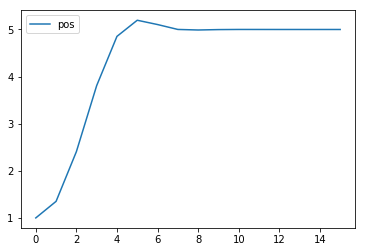

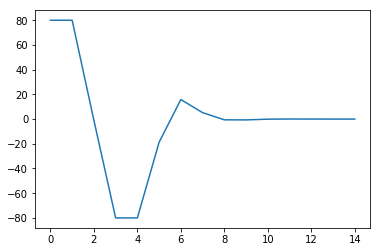

In [4]:
# Multiple Shooting Discrete Time OCP Base Class
# TODO: This is technically for Linear...  Need a f(x,u) for full non linear as a subclass to this.
# TODO: Break off a child class for LinearOptimalControlProblem/Convex Blah...
# class OptimalControlProblem(object):
    
#     def __init__(self, prediction_steps, horizon_length, num_states, num_inputs):
#         self.N = prediction_steps # Number of Prediction Steps
#         self.T = horizon_length # Horizon Length (seconds)
#         self.dt = self.T/self.N # Time Step (seconds)
#         self.num_states = num_states # Number of states in trajectory
#         self.num_inputs = num_inputs # Number of inputs in control
        
#         # TODO: QP vs NLP vs LP
#         self.problem = None
        
#         # Build Problem
#         self._build()
        

#     # Override this
#     def _build(self):
#         raise NotImplementedError()
    
#     # Override this
#     def _solve():
#         raise NotImplementedError()
    
#     #@property
#     #def X(self):
        
#     def value(self, name):
#         return 
#     # TODO: Set Path Constraints, Boundary Constraints, etc...


# Discrete Time Linear Optimal Control Panel Problem
class LinearOptimalControlProblem():
    # TODO: Set weight matrix
    # Set reference
    # Set Cost with Refefence
    def __init__(self, prediction_steps, horizon_length, num_states, num_inputs):
        
        self.N = prediction_steps # Number of Prediction Steps
        self.T = horizon_length # Horizon Length (seconds)
        self.dt = self.T/self.N # Time Step (seconds)
        self.num_states = num_states # Number of states in trajectory
        self.num_inputs = num_inputs # Number of inputs in control
        
        self.A = [] # State Transition Matrix (LTV)
        self.B = [] # Input Matrix (LTV)
        self.Q = np.diag(np.array([100,1])) # State Weights
        self.R = np.eye(self.num_inputs)*1e-6 # Input Weights

        # TODO: QP vs NLP vs LP
        self.problem = None
        
        # Build Problem
        self._build()

    def _build(self):
        
        # Create problem.  Need a type here for QP vs NLP
        self.problem = NonLinearProgramSolver()
        
        # State Transition Function (Discrete Time)
        A = MX.sym('A', self.num_states, self.num_states)
        B = MX.sym('B', self.num_states, self.num_inputs)
        x = MX.sym('x', self.num_states)
        u = MX.sym('u', self.num_inputs)
        x_dot = A@x + B@u
        
        self.f = Function('f',[A,x, B,u],[x_dot])  
    
        # TODO: Should this be here?
        # State Trajectory
        self._X = self.problem.add_variable('X', self.num_states, self.N)
        
        # Input Control
        self._U = self.problem.add_variable('U', self.num_inputs, self.N-1, lb=[-20], ub=[20])

        # Initial Condition
        self._x_0 = self.problem.add_parameter('x_0', self.num_states)
        
        # TODO: Move this down to the next child for the actual implementation
        # Reference Trajectory
        self._X_ref = self.problem.add_parameter('X_ref', self.num_states, self.N)
        
        # Time Varying Matrix Containers:
        # TODO: Non Time Varying Option
        # Create LTV State Transition + Input Matrices
        for i in range(self.N-1):     
            # State Transition Matrix (LTV)
            self.A.append(self.problem.add_parameter("A_"+str(i), self.num_states, self.num_states))
            
            #Input Matrix (LTV)
            self.B.append(self.problem.add_parameter("B_"+str(i), self.num_states, self.num_inputs))

        #################
        # Add Constraints
        #################
        
        # Initial Condition
        self.problem.add_eq_constraint(self._X[:,0], self._x_0)
        
        # Dynamics Constraints
        for i in range(self.N-1):
            self.problem.add_eq_constraint(self._X[:,i+1], self.f(self.A[i], self._X[:,i], self.B[i], self._U[:,i]))
    
        # Cost Functions
        cost = sum([(self._X[:, i]).T@self.Q@(self._X[:, i]) for i in range(self.N)]) \
               + sum([self._U[:, i].T@self.R@self._U[:,i] for i in range(self.N-1)])
        self.set_objective(cost)
        self.problem.set_output_level(1)
        
    def solve(self):
        self.problem.solve()
        
    # TODO: Move Down
    def set_initial(self, name, value):
        self.problem.set_initial_value(name, value=value)
        
    def set_value(self, name, value):
        self.problem.set_parameter_value(name, value=value)
        
    def set_objective(self, j):
        self.problem.minimize(j)
        return
               
    def set_reference(self, X_ref):
        self.problem.set_parameter_value('X_ref', value=X_ref.T)
    
    def set_model_matrix(self, A, B):
        # Loop and update parm values
        for i in range(self.N-1):
            self.problem.set_parameter_value("A_"+str(i), value=A[i])
            self.problem.set_parameter_value("B_"+str(i), value=B[i])
            
    def X(self):
        return self.problem.value('X')
    
    def U(self):
        return self.problem.value('U')
    

    
    
#####################
# Condensed Test
#####################
# Discrete Time Linear Optimal Control Panel Problem
class LinearCondensedOptimalControlProblem():
    # Set reference
    # Set Cost with Reference
    def __init__(self, prediction_steps, horizon_length, num_states, num_inputs, Q, R):
        
        self.N = prediction_steps # Number of Prediction Steps
        self.T = horizon_length # Horizon Length (seconds)
        self.dt = self.T/self.N # Time Step (seconds)
        self.num_states = num_states # Number of states in trajectory
        self.num_inputs = num_inputs # Number of inputs in control
        
        self.A = [] # State Transition Matrix (LTV)
        self.B = [] # Input Matrix (LTV)
        self.Q = Q # State Weights

        self.R = R # Input Weights

        # TODO: QP vs NLP
        self.problem = None
        
        # Build Problem
        self._build()

    def _build(self):
        
        # Create problem.  Need a type here for QP vs NLP
        self.problem = NonLinearProgramSolver()
        
        # Setup Parameters
        #self.A_qp = self.problem.add_parameter('A_qp', self.num_states * self.N, self.num_states)
        #self.B_qp = self.problem.add_parameter('B_qp', self.num_states * self.N, self.num_inputs * (self.N-1))
        
        # Place holder block matrices we use to build up and then send that to Casadi.  Ideally this matrix goes straight to
        # the qp solver
        self.A_N = BlockMatrix(self.N, 1, self.num_states, self.num_states)
        self.B_N = BlockMatrix(self.N, self.N-1, self.num_states, self.num_inputs)
        
        #print(f'A_qp: {self.A_qp.shape}')
        #print(f'B_qp: {self.B_qp.shape}')
        
        # TODO: Should this be here?
        # State Trajectory
        #self._X = self.problem.add_variable('X', self.num_states * self.N)
        #print(f'X: {self._X.shape}')
        
        # Input Control
        self._U = self.problem.add_variable('U', self.num_inputs * (self.N-1), lb=[-80], ub=[80])
        print(f'U: {self._U.shape}')
        
        self._H = self.problem.add_parameter('H', self.num_inputs * (self.N-1), self.num_inputs * (self.N-1))
        #print(f'H: {self._H.shape}')
        
        self._g = self.problem.add_parameter('g', self.num_inputs * (self.N-1), 1)
        #print(f'g: {self._g.shape}')
        
        
        # Initial Condition
        #self._x_0 = self.problem.add_parameter('x_0', self.num_states)
        
        # TODO: Move this down to the next child for the actual implementation
        # Reference Trajectory
        #self._X_ref = self.problem.add_parameter('X_ref', self.num_states * self.N)
        
        #################
        # Add Constraints
        #################
        
        # Initial Condition
        #self.problem.add_eq_constraint(self._X[0:self.num_states], self._x_0)
        
        # X = Aqp*X+Bqp*U # Eq 27 - Convex MPC Paper
        #self.problem.add_eq_constraint(self._X, self.A_qp@self._x_0+self.B_qp@self._U)

        # H = 2*(B_qp^T,@Q@B_qp + R) # Eq 31 - Convex MPC Paper
        #self.problem.add_eq_constraint(self._H, 2*(self.B_qp.T@self.Q@self.B_qp+self.R))
        
        # g = 2*B_qp^T@Q@(A_qp@x_0 - y) # Eq 32 - Convex MPC Paper
        #self.problem.add_eq_constraint(self._g, 2*self.B_qp.T@self.Q@(self.A_qp@self._x_0- self._X_ref))
                                       
                                       
        # Cost Function
        #X_err = self._X - self._X_ref
        #cost = self._X.T@self.Q@self._X + self._U.T@self.R@self._U
        #cost = X_err.T@self.Q@X_err + self._U.T@self.R@self._U
        
        cost = 0.5*self._U.T@self._H@self._U + self._U.T@self._g
        
        self.set_objective(cost)
        
       # self.problem.set_output_level(1)
        
    def solve(self):
        self.problem.solve()
        
    # TODO: Move Down
    def set_initial(self, name, value):
        self.problem.set_initial_value(name, value=value)
        
    def set_value(self, name, value):
        self.problem.set_parameter_value(name, value=value)
        
    def set_objective(self, j):
        self.problem.minimize(j)
        return
               
    def set_reference(self, X_ref):
        self.problem.set_parameter_value('X_ref', value=X_ref.T)
    
    def set_model_matrix(self, A, B, X_0, X_ref):
        
        # Loop and update param values
        # Note if not time varying can just compute the powers directly:
        #A_qp[i] = np.linalg.matrix_power(A, i)
        # Condense Formulation
        self.A_N[0, 0] = np.eye(self.num_states) # First State Identity
        for i in range(0,self.N-1): 
            self.A_N[i+1, 0] = self.A_N[i, 0]@A[i]
            self.B_N.fill_diagonal(self.A_N[i,0]@B[i], (-i-1))
        
        # Update Parameters
        #self.problem.set_parameter_value('A_qp', value=self.A_N.array.ravel(order='F'))
        #self.problem.set_parameter_value('B_qp', value=self.B_N.array.ravel(order='F'))
        
        self._x_0 = X_0
        H = 2*(self.B_N.array.T@self.Q@self.B_N.array+self.R)
        g = 2*self.B_N.array.T@self.Q@(self.A_N.array@X_0-X_ref)

        self.problem.set_parameter_value('H', value=H.ravel(order='F'))
        self.problem.set_parameter_value('g', value=g.ravel(order='F'))
        
            
    def X(self):
        return self.A_N.array@self._x_0+self.B_N.array@self.U()
        #return self.problem.value('X')
    
    def U(self):
        return self.problem.value('U')
 
N = 16
Q_qp = np.eye(2*N)*np.tile(np.array([10000,1]), N)
R_qp = np.eye(1*(N-1))*1e-1
ocp = LinearCondensedOptimalControlProblem(prediction_steps=N, horizon_length=1.5, num_states=2, num_inputs=1, Q=Q_qp, R=R_qp)

X_0 = np.array([[1,0]]).T
X_ref = np.tile(np.array([5,0]),N).reshape(-1,1)

print(X_ref.shape)
#ocp.set_value('x_0', X_0.ravel(order='F'))
#ocp.set_value('X_ref', X_ref.ravel(order='F'))


                   
# Dynamics Matrix (Continuous Time)
m = 1
A = np.array([[0,1],
              [0,0]])

B = np.array([[0],
              [1/m]])


#A = np.ones((13,13))
#B = np.ones((13,12))
# Convert to disrete with a Zero Order Hold
A_d, B_d = c2d_zoh(A,B,ocp.dt)

A_list = []
B_list = []

# Create Time Varying Matrix List
for j in range(ocp.N):
    A_list.append(A_d)
    B_list.append(B_d)
    

ocp.set_model_matrix(A=A_list, B=B_list, X_0=X_0, X_ref=X_ref) 
res = ocp.solve()
    
#ocp.set_initial('X', ocp.X())
ocp.set_initial('U', ocp.U())
res = ocp.solve()
#print(ocp.X().shape)
%matplotlib inline
#print(ocp.X()[0::2].ravel())
from pylab import plot, step, figure, legend, show, spy
plot(ocp.X()[0::2].ravel(),label="pos")
#plot(ocp.X()[1::2].ravel(),label="vel")
legend(loc="upper left")
figure()
plot(ocp.U().ravel(),label="pos")



In [5]:


nlp = NonLinearProgramSolver()
nlp.set_output_level(2)
num_states = 2
num_inputs = 1

A = MX.sym('A', num_states, num_states)
B = MX.sym('B', num_states, num_inputs)
x = MX.sym('x', num_states)
u = MX.sym('u', num_inputs)
x_dot = A@x + B@u
f = Function('f',[A,x, B,u],[x_dot])


m = 1
A = np.array([[0,1],
              [0,0]])

B = np.array([[0],
              [1/m]])


Ts = 0.1

A_d, B_d = c2d_zoh(A,B,Ts)

N = 20



# Condense
# X = A_qp*x0 + Beq*U
A_qp = np.zeros((N*num_states, num_states))
B_qp = np.ones((N*num_states, num_inputs))
X = np.zeros((num_states)).reshape(-1,1)
X_0 = np.array([[10,2]]).T
print(X_0)
A_qp[0:num_states] = np.eye(num_states)
A_d_prev = np.eye(num_states)
for i in range(N):
    A_d_next = A_d@A_d_prev
    A_qp[num_states*i:num_states*i+num_states] = A_d_next
    A_d_prev = A_d_next


# X = nlp.add_variable('X', num_states, N+1)
# x0 = nlp.add_parameter('x_0',num_states, value=[1,10])
# nlp.add_eq_constraint(X[:,0], x0)
# u = nlp.add_parameter('u', num_inputs, value=[0])

# A = nlp.add_parameter('A', num_states, num_states, value=A_d.T.flatten().tolist())
# B = nlp.add_parameter('B', num_states, num_inputs, value=B_d.T.flatten().tolist())

# for i in range(N):
#     nlp.add_eq_constraint(X[:,i+1], f(A, X[:,i], B, u))

# result = reshape(nlp.solve(), num_states, N+1)
# print(nlp.p)
# # ---- post-processing        ------
# %matplotlib inline

# from pylab import plot, step, figure, legend, show, spy
# plot(result[0,:].full().flatten(),label="pos")
# plot(result[1,:].full().flatten(),label="vel")
# #plot(t_vec, sol.value(X[1,:]),label="posy")
# #plot(t_vec, sol.value(X[5,:]),label="v")
# legend(loc="upper left")
# figure()

# print(result)

[[10]
 [ 2]]


In [6]:
%%timeit

    
#ocp.set_initial('X', ocp.X())
ocp.set_initial('U', ocp.U())
res = ocp.solve()


343 µs ± 964 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# BACKUP

# Block Matrix
# Let's you do "sub" matrix blocks inside a larger matrix
import numpy as np

class BlockMatrix():
    def __init__(self, rows = 1, cols = 1, block_height = 1, block_width=1, init_val = 0.):
        self.shape = [rows, cols]
        #self.block_height = block_height
        #self.block_width = block_width
        self._array = np.full((rows*block_height, cols*block_width), init_val)
        self.strides = self._array.strides
        self._block_array = as_strided(self._array, 
                                       shape=(rows,cols,block_height,block_width), 
                                       strides=(block_height*self.strides[0], 
                                                block_width*self.strides[1], 
                                                self.strides[0], 
                                                self.strides[1]))
    
        # Cache for speed up of diagonals setting
        self.idx = {}
        for i in range(max(self.shape[0], self.shape[1])):
            self.idx[i] = np.nonzero(np.eye(self.shape[0], self.shape[1], i))
            self.idx[-i] = np.nonzero(np.eye(self.shape[0], self.shape[1], -i))
        
        
    def fill_diagonal(self, val, k = 0):
#        self._array = self._array + np.kron(np.eye(self.shape[0], self.shape[1], k=k), val)
    
        #np.nonzero(np.eye(self.shape[0], self.shape[1], k))
        
        #self._block_array[np.nonzero(np.eye(self.shape[0], self.shape[1], k))] = val
        #a = (np.eye(self.shape[0], self.shape[1]), k)
        self._block_array[self.idx[k]] = val
        return

#         j_start = max(k, 0)
#         i_start = -k + j_start
#         i_end = self.shape[0]
#         for i in range(i_start, i_end):
#             j = j_start+(i-i_start)
#             if(i >= self.shape[0] or j >= self.shape[1]):
#                 break
                
#             self[i, j] = val
                
    @property
    def array(self):
        return self._array
    
    def __getitem__(self, pos):
        row, col = pos
        return self._block_array[pos[0], pos[1]]
    
        #row_idx = row * self.block_height
        #col_idx = col * self.block_width
        #return self._array[row_idx:row_idx + self.block_height, col_idx:col_idx + self.block_width]
    
    def __setitem__(self, pos, val):
        
        # TODO: Checks for correct array size, etc
        row, col = pos
        self._block_array[pos[0], pos[1]] = val
        
        #row_idx = row * self.block_height
        #col_idx = col * self.block_width
        
        #self._array[row_idx:row_idx + self.block_height, col_idx:col_idx + self.block_width] = val

from numpy.lib.stride_tricks import as_strided


#N = 4
#a = np.array([[1,2,3],[4,5,6],[7,8,9]])

# b will be the block-diagonal array.
#b = np.zeros((3*N, 3*N), dtype=a.dtype)

#bstr = b.strides
#print("Strides")
#print(bstr)
#c = as_strided(b, shape=(N,N,3,3), strides=(3*bstr[0], 3*bstr[1], bstr[0], bstr[1]))
#print(c)
# Assign a to the diagonal blocks.
#c[0, 1] = a
#print(c.shape)
#print(b)



#b = diag_block_mat_slicing((np.array([[2,2],[3,4]]),np.array([[2,2],[3,4]]),np.array([[2,2],[3,4]])))
#print(b)
#bm = BlockMatrix(3, 3, 2, 2)
#print(bm[0,0])
#bm[0,0] = np.array([[1,2],[3,4]])
#print(bm[0,0])
#print(bm.array)
#bm.array = np.array([[2,2],[3,4]])
#bm.fill_diagonal(np.array([[1,2],[3,4]]), -2)
#bm.fill_diagonal(np.array([[2,2],[3,4]]), 0)
#print(bm.array)

#print(bm.array)
#bm[0,0] = np.ones((2,2))*11
#bm.set_item(0,0,np.ones((2,2))*11)
#print(bm.array)
#bm[0,0]
#bm.get_item(0,0)